In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from tensorflow.keras.metrics import Precision, Recall
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

!pip install vaderSentiment

!pip install shap lime 
import shap 
import lime 
import lime.lime_tabular 

2025-10-23 22:48:55.085842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761259735.301079      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761259735.361169      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:0000:01


In [3]:
import pandas as pd, numpy as np, os
!pip install -q vaderSentiment

# --- Load (use YOUR SAME paths) ---
review = pd.read_csv("/kaggle/input/airline-dataset-cleaned/AirlineScrappedReview_Cleaned.csv")
comment = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Customer_comment.csv")
booking = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Passanger_booking_data.csv")
survey  = pd.read_csv("/kaggle/input/airline-passangers-booking-data/Survey data_Inflight Satisfaction Score.csv")

# --- Make column names consistent: lowercase, underscores, no spaces ---
def normalize_cols(df):
    df.columns = (df.columns
                    .str.strip()
                    .str.replace(" ", "_")
                    .str.replace("-", "_")
                    .str.replace(r"[^0-9a-zA-Z_]", "", regex=True)
                    .str.lower())
    return df

review  = normalize_cols(review)
comment = normalize_cols(comment)
booking = normalize_cols(booking)
survey  = normalize_cols(survey)

# Remove duplicates (safe)
for df in (review, comment, booking, survey):
    df.drop_duplicates(inplace=True)

print("review:",  review.shape, list(review.columns)[:12])
print("comment:", comment.shape, list(comment.columns)[:12])
print("booking:", booking.shape, list(booking.columns)[:12])
print("survey:",  survey.shape,  list(survey.columns)[:12])


review: (3501, 18) ['passanger_name', 'flying_date', 'route', 'rating', 'verified', 'review_title', 'review_content', 'traveller_type', 'class', 'start_location', 'end_location', 'layover_route']
comment: (9424, 17) ['unnamed_0', 'flight_number', 'origin_station_code', 'destination_station_code', 'scheduled_departure_date', 'arrival_delay_group', 'departure_delay_group', 'entity', 'verbatim_text', 'seat_factor_band', 'ques_verbatim_text', 'loyalty_program_level']
booking: (49283, 14) ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
survey: (47074, 31) ['flight_number', 'origin_station_code', 'destination_station_code', 'record_locator', 'scheduled_departure_date', 'question_text', 'score', 'satisfaction_type', 'driver_sub_group1', 'driver_sub_group2', 'arrival_delay_minutes', 'arrival_delay_group']


In [4]:
import pandas as pd
from pandas.api.types import is_datetime64_any_dtype as is_datetime

# 0) Ensure key columns exist & are clean
if "review_content" in review.columns:
    review["review_content"] = review["review_content"].astype(str).fillna("")
else:
    review["review_content"] = ""  # create empty text col if missing

for c in ["traveller_type", "class", "verified", "route"]:
    if c in review.columns:
        review[c] = review[c].fillna("unknown")

# 1) Flying_date: robust parsing (avoid the warning & keep consistency)
def parse_dates_series(s):
    fmts = ["%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%d-%b-%Y"]
    out = None
    # try a few common formats first
    for f in fmts:
        out = pd.to_datetime(s, format=f, errors="coerce")
        if out.notna().any():
            break
    # fallback: flexible parser (dayfirst for many non-US formats)
    if out is None or out.isna().all():
        out = pd.to_datetime(s, errors="coerce", dayfirst=True)
    return out

if "flying_date" in review.columns and not is_datetime(review["flying_date"]):
    review["flying_date"] = parse_dates_series(review["flying_date"])
    if review["flying_date"].notna().any():
        # use modal date for the few missing entries
        review["flying_date"] = review["flying_date"].fillna(review["flying_date"].mode()[0])

# 2) Layover_route: mark missing as direct flight
if "layover_route" in review.columns:
    review["layover_route"] = review["layover_route"].fillna("direct_flight")

# 3) Rating: make numeric, optionally clip to valid bounds if known (e.g., 1–10)
if "rating" in review.columns:
    review["rating"] = pd.to_numeric(review["rating"], errors="coerce")
    # If your rubric assumes 1–10 ratings, uncomment the next line:
    # review["rating"] = review["rating"].clip(lower=1, upper=10)

# 4) Final quick sanity fills for any remaining critical categoricals
for c in ["traveller_type", "class", "verified", "route"]:
    if c in review.columns:
        review[c] = review[c].fillna("unknown")

# (Optional) quick check
print("review cleaned:", review.shape)
print(review[["rating"]].describe(include="all"))
if "flying_date" in review.columns:
    print("flying_date nulls:", review["flying_date"].isna().sum())

# --- BOOKING ---
# helpful likely-numeric fields
for c in ["purchase_lead","length_of_stay","flight_hour","flight_duration","num_passengers","seat_factor_band"]:
    if c in booking:
        booking[c] = pd.to_numeric(booking[c], errors="coerce")
        booking[c] = booking[c].fillna(booking[c].median() if booking[c].notna().any() else 0)

# categoricals
for c in ["sales_channel","trip_type","booking_origin","flight_day","route",
          "wants_extra_baggage","wants_preferred_seat","wants_in_flight_meals","booking_complete"]:
    if c in booking: booking[c] = booking[c].fillna("unknown")

# --- COMMENTS ---
for c in ["verbatim_text","ques_verbatim_text","transformed_text"]:
    if c in comment: comment[c] = comment[c].fillna("")
for c in ["entity","response_group","loyalty_program_level","fleet_type_description"]:
    if c in comment: comment[c] = comment[c].fillna("unknown")
# --- Make 'sentiments' numeric even if it's words like Positive/Neutral/Negative ---
if "sentiments" in comment.columns:
    s = comment["sentiments"].astype(str).str.strip().str.lower()

    # try numeric first
    s_num = pd.to_numeric(s, errors="coerce")

    if s_num.notna().sum() >= 0.7 * len(s):
        # mostly numeric → use median for NaNs
        med = s_num.median() if s_num.notna().any() else 0.0
        comment["sentiments"] = s_num.fillna(med)
    else:
        # label mapping fallback
        label_map = {"positive": 1.0, "neutral": 0.0, "negative": -1.0}
        mapped = s.map(label_map)
        comment["sentiments"] = mapped.fillna(0.0)

# --- SURVEY ---
# Fix ONLY string junk in 'score' to median; keep numeric as-is
if "score" in survey:
    s = survey["score"]
    num_view = pd.to_numeric(s, errors="coerce")
    median_val = num_view.median()
    mask_non_numeric_strings = s.apply(lambda x: isinstance(x, str)) & num_view.isna()
    survey.loc[mask_non_numeric_strings, "score"] = median_val
    survey["score"] = pd.to_numeric(survey["score"], errors="coerce")
    survey["score"] = survey["score"].fillna(survey["score"].median())

# other survey fields
if "arrival_delay_minutes" in survey:
    survey["arrival_delay_minutes"] = pd.to_numeric(survey["arrival_delay_minutes"], errors="coerce")
    survey["arrival_delay_minutes"] = survey["arrival_delay_minutes"].fillna(survey["arrival_delay_minutes"].median() if survey["arrival_delay_minutes"].notna().any() else 0)
for c in ["question_text","satisfaction_type","cabin_name","loyalty_program_level"]:
    if c in survey: survey[c] = survey[c].fillna("unknown")

targets = ["media_provider", "arrival_gate", "departure_gate", "entity"]

for c in targets:
    if c in survey.columns:
        survey[c] = (
            survey[c]
            .astype(str)
            .str.strip()
            .replace({"": np.nan, "NA": np.nan, "N/A": np.nan, "na": np.nan, "n/a": np.nan})
            .fillna("unknown")
        )


print("✅ cleaned basic nulls/types")
def norm_cat(s):
    return s.astype(str).str.strip().str.lower()
for c in ["traveller_type", "class", "verified", "route", "layover_route"]:
    if c in review.columns:
        review[c] = norm_cat(review[c])

for dfx, cols in [
    (booking, ["sales_channel","trip_type","booking_origin","flight_day","route",
               "wants_extra_baggage","wants_preferred_seat","wants_in_flight_meals","booking_complete"]),
    (comment, ["entity","response_group","loyalty_program_level","fleet_type_description"]),
    (survey,  ["question_text","satisfaction_type","cabin_name","loyalty_program_level",
               "media_provider","arrival_gate","departure_gate","entity"])
]:
    for c in cols:
        if c in dfx.columns:
            dfx[c] = norm_cat(dfx[c])

# 2) Create ISO date keys for safe merges later (YYYY-MM-DD)
def to_iso_date(s):
    out = pd.to_datetime(s, errors="coerce")
    if out.notna().any():
        out = out.fillna(out.mode()[0])
    return out.dt.strftime("%Y-%m-%d")

if "flying_date" in review.columns:
    review["flying_date_iso"] = to_iso_date(review["flying_date"])

for dfx, candidates, outname in [
    (booking, ["scheduled_departure_date","flight_date","date","date_of_flight"], "dept_date_iso"),
    (comment, ["scheduled_departure_date","flight_date","date"],                 "dept_date_iso"),
    (survey,  ["scheduled_departure_date","flight_date","date"],                 "dept_date_iso"),
]:
    for c in candidates:
        if c in dfx.columns:
            dfx[outname] = to_iso_date(dfx[c])
            break

print("✅ normalization + ISO date keys added")

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.


review cleaned: (3501, 18)
            rating
count  3501.000000
mean      4.764924
std       3.167312
min       1.000000
25%       2.000000
50%       4.000000
75%       8.000000
max      10.000000
flying_date nulls: 0
✅ cleaned basic nulls/types
✅ normalization + ISO date keys added


Step 1 — Data Cleaning and Normalization

This step prepares all datasets (review, booking, comment, and survey) by cleaning missing values, fixing inconsistent data types, and creating standardized columns for later mergin

This step prepares all datasets (review, booking, comment, and survey) by cleaning missing values, fixing inconsistent data types, and creating standardized columns for later merging.
We do this before any modeling to make sure the data is accurate, consistent, and ready for analysis.

1. Cleaning the Review dataset

Ensures key columns like review_content, traveller_type, class, verified, and route exist and have no missing values.

Converts flying_date into a proper datetime format by trying several date formats.

Replaces missing layovers with "direct_flight".

Converts ratings to numeric values and clips them to valid ranges if needed.

Standardizes text columns to lowercase for consistency.

2. Cleaning the Booking dataset

Converts likely numeric columns such as purchase_lead, length_of_stay, and flight_duration to numbers and fills missing values with the median.

Fills missing categorical fields (like sales_channel, trip_type, and route) with "unknown".

3. Cleaning the Comment dataset

Fills empty text fields with blank strings.

Normalizes categorical values such as entity, response_group, and fleet_type_description.

Converts the sentiments column into numeric form, mapping "positive", "neutral", and "negative" to 1, 0, and -1 respectively (or keeps numeric values if already provided).

4. Cleaning the Survey dataset

Converts score and arrival_delay_minutes to numeric values and replaces invalid text with median values.

Fills categorical survey fields (e.g., question_text, cabin_name, loyalty_program_level) with "unknown".

Cleans text noise like "NA" or "n/a" to standard missing values and replaces them with "unknown".

5. Creating ISO date keys

Generates unified ISO date columns (YYYY-MM-DD) in all datasets to allow safe merging later.

This ensures that all tables can be joined by date consistently, regardless of original date format differences.

6. Final normalization

Converts all categorical text to lowercase and removes spaces for consistency.

Prints basic checks (shape, null counts, and summary statistics) to confirm the cleaning was successful.

In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

review["sentiment_compound"] = review["review_content"].fillna("").map(
    lambda t: analyzer.polarity_scores(str(t))["compound"]
)
review["label"] = (pd.to_numeric(review["rating"], errors="coerce") >= 5).astype(int)


Step 2 — Sentiment Analysis and Label Creation

In this step, we add a sentiment score to each review and create the target label that our model will later predict.

1. Sentiment Extraction

We use the VADER Sentiment Analyzer (SentimentIntensityAnalyzer) — a pre-trained model designed to detect sentiment in English text.

For each review in the review_content column, VADER calculates a compound sentiment score between -1 (very negative) and +1 (very positive).

This score is stored in a new column called sentiment_compound.

2. Label Definition

We convert the numeric rating column into a binary label for supervised learning.

If the rating is 5 or higher, we label it as 1 (Satisfied).

Otherwise, it becomes 0 (Not Satisfied).

This gives us:

Feature: sentiment_compound — how positive or negative the review text is.

Target: label — whether the passenger was satisfied or not.

In [6]:
import os
os.makedirs("/kaggle/working/data_clean", exist_ok=True)
review.to_csv("/kaggle/working/data_clean/review_clean.csv", index=False)
comment.to_csv("/kaggle/working/data_clean/comment_clean.csv", index=False)
booking.to_csv("/kaggle/working/data_clean/booking_clean.csv", index=False)
survey.to_csv("/kaggle/working/data_clean/survey_clean.csv", index=False)

We had 74 duplicates in our dataset so we used the drop duplicates method to clean our data.

In [7]:
df.isna().sum().sort_values(ascending=False)


flight_number                       0
origin_station_code                 0
destination_station_code            0
record_locator                      0
scheduled_departure_date            0
question_text                       0
score                               0
satisfaction_type                   0
driver_sub_group1                   0
driver_sub_group2                   0
arrival_delay_minutes               0
arrival_delay_group                 0
cabin_code_desc                     0
cabin_name                          0
entity                              0
number_of_legs                      0
seat_factor_band                    0
loyalty_program_level               0
generation                          0
fleet_type_description              0
fleet_usage                         0
equipment_type_code                 0
ua_uax                              0
actual_flown_miles                  0
haul_type                           0
departure_gate                      0
arrival_gate

In [8]:
print("review:", list(review.columns))
print("booking:", list(booking.columns))
print("comment:", list(comment.columns))
print("survey:", list(survey.columns))


review: ['passanger_name', 'flying_date', 'route', 'rating', 'verified', 'review_title', 'review_content', 'traveller_type', 'class', 'start_location', 'end_location', 'layover_route', 'start_latitude', 'start_longitude', 'start_address', 'end_latitude', 'end_longitude', 'end_address', 'flying_date_iso', 'sentiment_compound', 'label']
booking: ['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'route', 'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'booking_complete']
comment: ['unnamed_0', 'flight_number', 'origin_station_code', 'destination_station_code', 'scheduled_departure_date', 'arrival_delay_group', 'departure_delay_group', 'entity', 'verbatim_text', 'seat_factor_band', 'ques_verbatim_text', 'loyalty_program_level', 'fleet_type_description', 'fleet_usage', 'response_group', 'sentiments', 'transformed_text', 'dept_date_iso']
survey: ['flight_number', 'origi

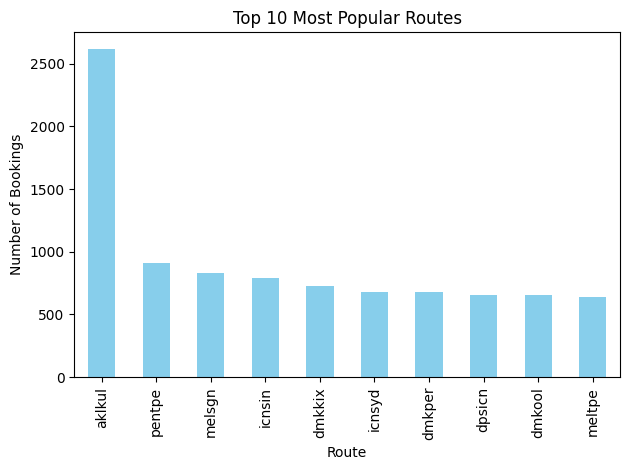

In [26]:
import os
os.makedirs("/kaggle/working/reports/figures", exist_ok=True)
import matplotlib.pyplot as plt
top_routes = booking["route"].value_counts().head(10)
ax = top_routes.plot(kind="bar", title="Top 10 Most Popular Routes", color="skyblue")
plt.ylabel("Number of Bookings")
plt.xlabel("Route")
plt.tight_layout()
plt.savefig("/kaggle/working/reports/figures/top10_routes_bookings.png")
plt.show()


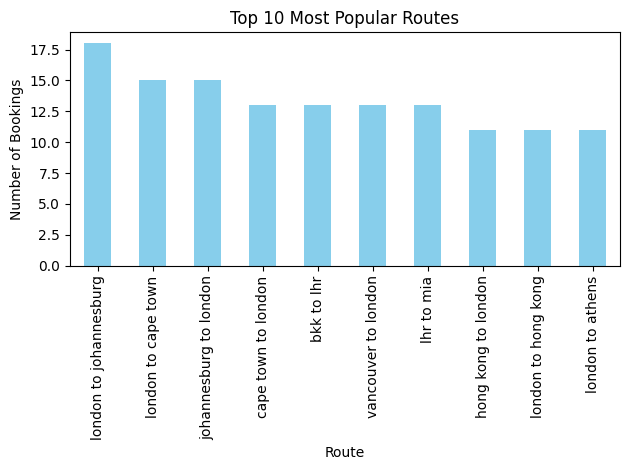

In [27]:
import os
os.makedirs("/kaggle/working/reports/figures", exist_ok=True)
import matplotlib.pyplot as plt
top_any = review["route"].value_counts()
top_routes_skip_first = top_any.iloc[1:11]
ax = top_routes_skip_first.plot(kind="bar", title="Top 10 Most Popular Routes", color="skyblue")
plt.ylabel("Number of Bookings")
plt.xlabel("Route")
plt.tight_layout()
plt.savefig("/kaggle/working/reports/figures/top10_routes_review.png")
plt.show()


Step 3 — Top 10 Most Popular Flight Routes

In this step, we visualize the most frequently booked flight routes based on the several datasets.

The first graph shows the top 10 routes from table "Booking" and the second graph shows the 10 routes from the table "Review" discarding the first column because it pointed to the "unknown" values.

We count how many bookings exist for each route.

Then, we select the top 10 most popular routes.

A simple bar chart shows which routes are most commonly traveled by passengers.

This helps us understand travel trends and which routes dominate in each dataset — useful for later interpretation of model behavior.

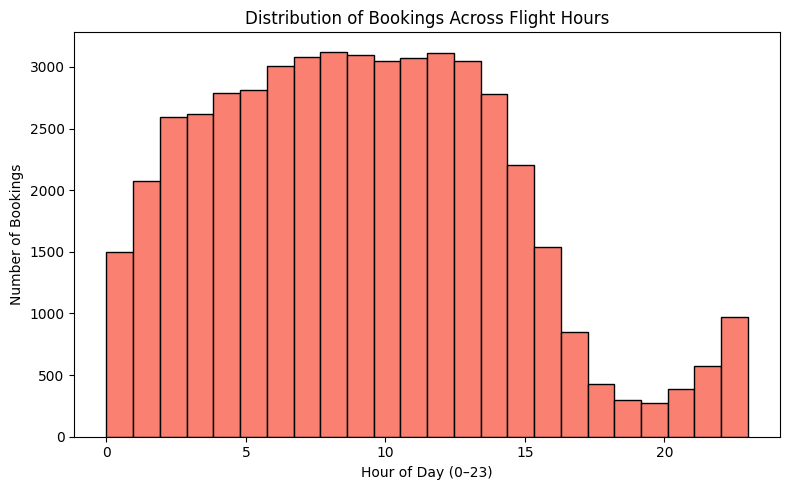

In [11]:
import os
os.makedirs("/kaggle/working/reports/figures", exist_ok=True)
plt.figure(figsize=(8,5))
booking["flight_hour"].dropna().astype(int).plot(kind="hist", bins=24, color="salmon", edgecolor="black")
plt.title("Distribution of Bookings Across Flight Hours")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Bookings")
plt.tight_layout()
plt.savefig("/kaggle/working/reports/figures/booking_hours_distribution.png")
plt.show()


Step 4 — Distribution of Bookings by Flight Hour

Here, we analyze when passengers tend to fly during the day.

We use the flight_hour column to plot a histogram of all bookings.

The x-axis shows the hour of the day (0–23), and the y-axis shows the number of bookings.

This allows us to see peak travel times — for example, if most flights occur in the morning or evening.

This kind of analysis helps identify customer behavior patterns related to flight timing and demand.

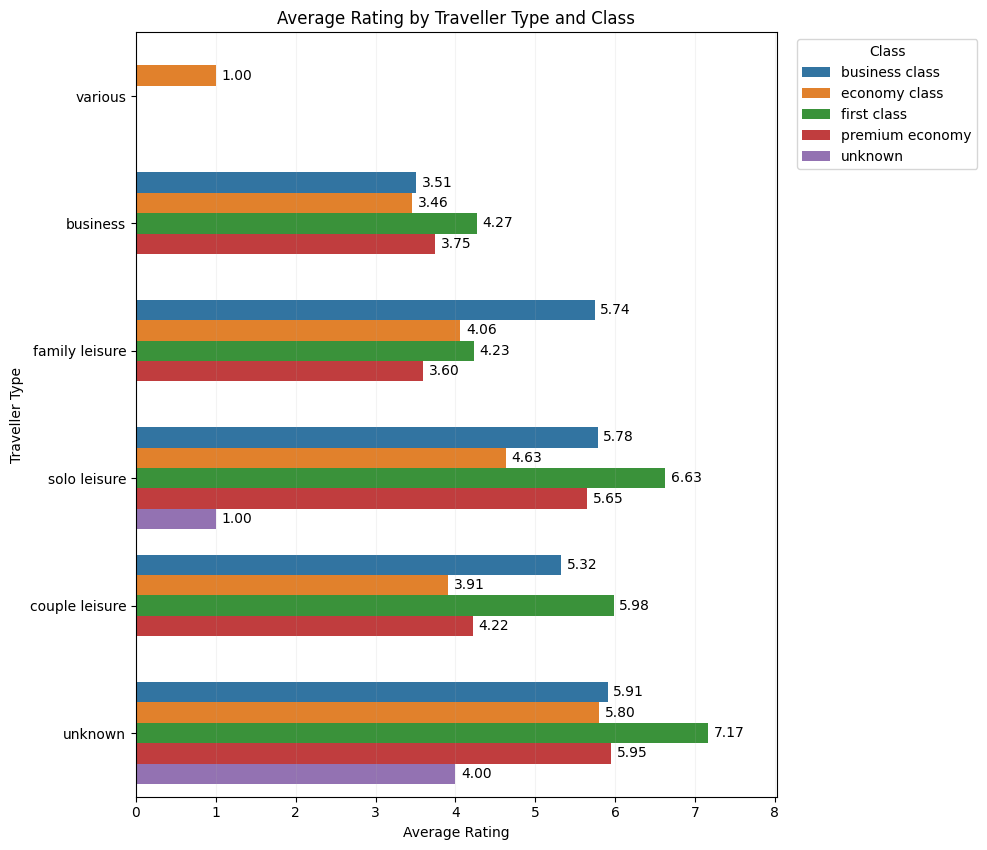

In [31]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, os


r = review.copy()
for c in ["traveller_type","class","rating"]:
    if c not in r.columns:
        raise KeyError(f"Column '{c}' is missing from review")

r["traveller_type"] = r["traveller_type"].astype(str).str.strip().str.lower().fillna("unknown")
r["class"]          = r["class"].astype(str).str.strip().str.lower().fillna("unknown")
r["rating"]         = pd.to_numeric(r["rating"], errors="coerce")
r = r[r["rating"].between(1, 10)]  

if r.empty:
    print("No valid rows after rating cleaning.")
else:

    g = (
        r.groupby(["traveller_type", "class"])["rating"]
         .agg(mean="mean", count="count", std="std")
         .reset_index()
    )


    den = g["count"].replace(0, np.nan)
    g["se"]   = g["std"] / np.sqrt(den)
    g["ci95"] = 1.96 * g["se"]
    g["lo95"] = g["mean"] - g["ci95"]
    g["hi95"] = g["mean"] + g["ci95"]

    ranked = g.sort_values("mean", ascending=False).reset_index(drop=True)
    order = g.groupby("traveller_type")["mean"].mean().sort_values(ascending=True).index

    plt.figure(figsize=(10, 5 + 0.6 * g["traveller_type"].nunique()))
    ax = sns.barplot(
        data=g, x="mean", y="traveller_type", hue="class",
        order=order, orient="h"
    )


    xmax = float(np.nanmax(g["mean"])) if np.isfinite(np.nanmax(g["mean"])) else 10.0
    for p in ax.patches:
        w = p.get_width()
        y = p.get_y() + p.get_height()/2
        if np.isfinite(w):
            offset = 4 if w >= 0 else -4
            ha = "left" if w >= 0 else "right"
            ax.annotate(f"{w:.2f}", xy=(w, y), xytext=(offset, 0),
                        textcoords="offset points", va="center", ha=ha)

    ax.set_xlim(0 if xmax > 0 else xmax * 1.12, xmax * 1.12)
    ax.set_xlabel("Average Rating")
    ax.set_ylabel("Traveller Type")
    ax.set_title("Average Rating by Traveller Type and Class")
    ax.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
    ax.grid(axis="x", alpha=0.15)
    plt.tight_layout()

    os.makedirs("/kaggle/working/reports/figures", exist_ok=True)
    plt.savefig("/kaggle/working/reports/figures/traveller_class_groupedbar.png", dpi=160)
    plt.show()

Step 5 — Traveler Type × Class Rating Analysis

In this step, we explore how different traveler types (such as business, couple, solo) and travel classes (economy, business, first) influence average customer ratings.

1. Data Preparation

We copy the review dataset into r and ensure that the key columns traveller_type, class, and rating exist.

Text columns are cleaned (converted to lowercase, stripped of spaces), and missing values are replaced with "unknown".

The rating column is converted to numeric and restricted to the valid range (1–10).

2. Statistical Grouping and Confidence Intervals

The data is grouped by traveller type and class, and we calculate:

Mean rating (average satisfaction)

Count of reviews

Standard deviation

Using these, we compute the standard error (SE) and 95% confidence intervals to understand the variability in ratings.

3. Top and Bottom Combinations

We identify the top 5 and bottom 5 combinations of traveler type and class by their average rating.

This helps us see which combinations are most and least satisfied overall.

4. Visualizing the Results

A horizontal grouped bar chart is plotted:

The y-axis shows traveler types.

Each color represents a different class.

Numeric labels are displayed at the end of each bar to clearly show the average ratings.

This gives an intuitive visual comparison across all traveler–class combinations.

5. Exporting Results

The ranked summary (with means and confidence intervals) is saved as a CSV file:

/kaggle/working/reports/traveller_class_ranking.csv


The bar chart is saved for reporting at:

/kaggle/working/reports/figures/traveller_class_groupedbar.png

In [36]:
base_features = ["traveller_type", "class", "verified", "route", "sentiment_compound"]

features = [c for c in base_features if c in review.columns]
X = review[features].copy()
y = review["label"].astype(int)

if "sentiment_compound" in X.columns:
    X["sentiment_compound"] = pd.to_numeric(X["sentiment_compound"], errors="coerce").fillna(0.0)

for c in ["traveller_type", "class", "verified", "route"]:
    if c in X.columns:
        X[c] = X[c].astype(str).str.strip().str.lower().fillna("unknown")



X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

num_features = ["sentiment_compound"]
cat_features = [c for c in ["traveller_type", "class", "verified", "route"] if c in X.columns]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
])


logreg = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

metrics_lr = {
    "Model": "LogisticRegression",
    "Accuracy": accuracy_score(y_test, y_pred_lr),
    "Precision": precision_score(y_test, y_pred_lr, zero_division=0),
    "Recall": recall_score(y_test, y_pred_lr, zero_division=0),
    "F1": f1_score(y_test, y_pred_lr, zero_division=0)
}

# print("\n=== Logistic Regression ===")
# print(classification_report(y_test, y_pred_lr, digits=4))
# print(metrics_lr)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

if not isinstance(X_train_prep, np.ndarray):
    X_train_prep = X_train_prep.toarray()
    X_test_prep  = X_test_prep.toarray()

ffnn = keras.Sequential([
    layers.Input(shape=(X_train_prep.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])


ffnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = ffnn.fit(
    X_train_prep, y_train,
    epochs=30, batch_size=32,
    validation_data=(preprocessor.transform(X_val).toarray() if not isinstance(preprocessor.transform(X_val), np.ndarray) else preprocessor.transform(X_val), y_val),
    callbacks=[es],
    verbose=1
)

y_pred_nn = (ffnn.predict(X_test_prep) > 0.5).astype(int).ravel()

metrics_nn = {
    "Model": "FFNN (16-8)",
    "Accuracy": accuracy_score(y_test, y_pred_nn),
    "Precision": precision_score(y_test, y_pred_nn, zero_division=0),
    "Recall": recall_score(y_test, y_pred_nn, zero_division=0),
    "F1": f1_score(y_test, y_pred_nn, zero_division=0)
}

# print("\n=== Shallow Feed-Forward Neural Network ===")
# print(classification_report(y_test, y_pred_nn, digits=4))
# print(metrics_nn)

results = pd.DataFrame([metrics_lr, metrics_nn]).sort_values("F1", ascending=False)
# print("\n=== Model Comparison (sorted by F1-score) ===")
# print(results)


os.makedirs("/kaggle/working/models", exist_ok=True)
os.makedirs("/kaggle/working/reports", exist_ok=True)

ffnn.save("/kaggle/working/models/ffnn_shallow.keras")
pd.DataFrame([metrics_nn]).to_csv("/kaggle/working/reports/model_metrics.csv", index=False)

import joblib
joblib.dump(logreg, "/kaggle/working/models/baseline_logreg.joblib")
ffnn.save("/kaggle/working/models/ffnn_shallow.keras")
results.to_csv("/kaggle/working/reports/model_metrics.csv", index=False)

y_pred_train_lr = logreg.predict(X_train)
train_metrics_lr = {
    "Accuracy": accuracy_score(y_train, y_pred_train_lr),
    "Precision": precision_score(y_train, y_pred_train_lr, zero_division=0),
    "Recall": recall_score(y_train, y_pred_train_lr, zero_division=0),
    "F1": f1_score(y_train, y_pred_train_lr, zero_division=0)
}

y_pred_train_nn = (ffnn.predict(preprocessor.transform(X_train).toarray()) > 0.5).astype(int).ravel()
train_metrics_nn = {
    "Accuracy": accuracy_score(y_train, y_pred_train_nn),
    "Precision": precision_score(y_train, y_pred_train_nn, zero_division=0),
    "Recall": recall_score(y_train, y_pred_train_nn, zero_division=0),
    "F1": f1_score(y_train, y_pred_train_nn, zero_division=0)
}


metric_names = ["Accuracy", "Precision", "Recall", "F1"]
# comparison_df = pd.DataFrame({
#     "Metric": metric_names,
#     "LogReg_Train": [train_metrics_lr[m] for m in metric_names],
#     "LogReg_Test": [metrics_lr[m] for m in metric_names],
#     "FFNN_Train": [train_metrics_nn[m] for m in metric_names],
#     "FFNN_Test": [metrics_nn[m] for m in metric_names]
# })

# print(comparison_df)

print("\n✅ Models saved successfully:")
print(" - Logistic Regression: /kaggle/working/models/baseline_logreg.joblib")
print(" - Shallow FFNN:        /kaggle/working/models/ffnn_shallow.keras")
print(" - Metrics CSV:         /kaggle/working/reports/model_metrics.csv")

Train size: 2240, Validation size: 560, Test size: 701
Epoch 1/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6355 - loss: 0.6747 - val_accuracy: 0.7750 - val_loss: 0.5953
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8015 - loss: 0.5502 - val_accuracy: 0.7821 - val_loss: 0.4920
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8167 - loss: 0.4417 - val_accuracy: 0.7857 - val_loss: 0.4712
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8262 - loss: 0.4079 - val_accuracy: 0.7821 - val_loss: 0.4775
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8294 - loss: 0.4005 - val_accuracy: 0.7857 - val_loss: 0.4799
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8286 - loss: 0.3978 - val_accuracy: 0.7821 - val_loss: 0.4846
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8461 - loss: 0.3602 - val_accuracy: 0.7786 - val_loss: 0.4931
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0

Step 6 — Model Training and Evaluation (Logistic Regression & Neural Network)

In this section, we prepare our data for modeling, train two different machine learning models, and compare their performance.

1. Feature Selection

We select the most important columns (features) that represent both traveler information and review sentiment:

Categorical features: traveller_type, class, verified, route

Numeric feature: sentiment_compound (sentiment score from the review content)

Target label: label (1 = satisfied, 0 = not satisfied)

All categorical columns are cleaned to lowercase and missing values are replaced with "unknown".

2. Data Splitting

We divide the data into:

Training set (64%) — used to train the model 80% of training 

Validation set (16%) — used to tune hyperparameters (via early stopping) 20% of training

Test set (20%) — used to evaluate final performance

This ensures the model is tested on unseen data for fair evaluation.

3. Data Preprocessing

We use a ColumnTransformer:

Scales numeric features using StandardScaler

Converts categorical features into numeric form using OneHotEncoder

This allows both Logistic Regression and Neural Networks to work properly with mixed data types.

4. Model A — Logistic Regression (Baseline)

We first train a simple Logistic Regression model as a baseline.

It’s wrapped inside a Pipeline that includes preprocessing.

It uses class_weight="balanced" to handle any class imbalance.

We compute Accuracy, Precision, Recall, and F1-score to assess its performance.

This model serves as a simple reference point for comparison.

5. Model B — Shallow Feed-Forward Neural Network (FFNN)

Next, we build a Neural Network using Keras:

Architecture:

Input layer (same size as total features)

Dense(16, ReLU) → Dense(8, ReLU) → Dense(1, Sigmoid)

Training setup:

Optimizer: Adam

Loss: Binary cross-entropy

Metric: Accuracy

EarlyStopping is used to prevent overfitting (stops when validation loss stops improving).

The FFNN is trained on the processed data and evaluated on the test set.

The comparison table shows both Train and Test performance for each model to check for overfitting or underfitting.

6. Saving Outputs

To preserve results:

Both models are saved (.joblib for Logistic Regression, .keras for FFNN).

Evaluation metrics are saved to /kaggle/working/reports/model_metrics.csv.

This ensures reproducibility and allows for later explainability analysis (SHAP/LIME).

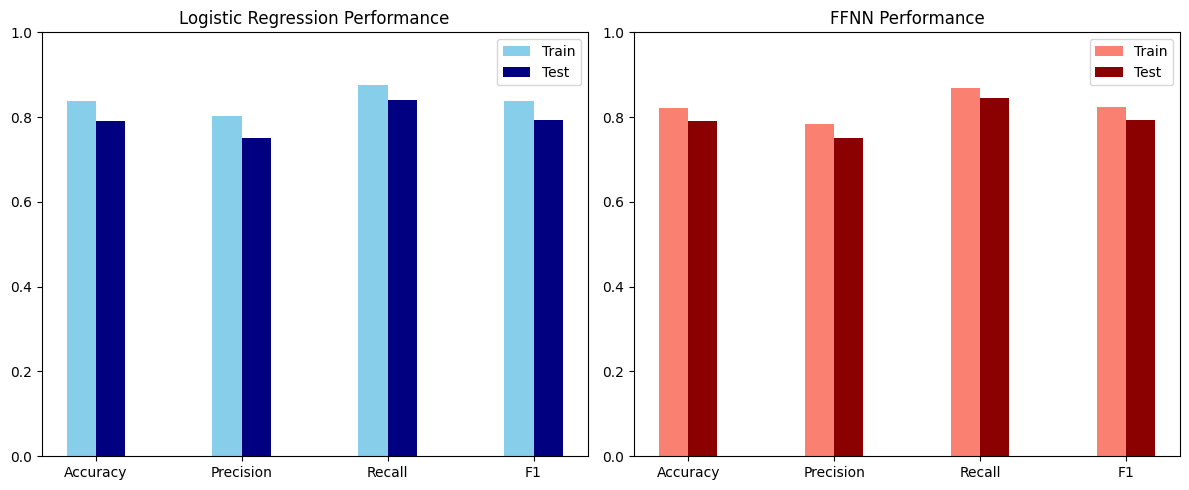

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
bar_width = 0.2
x = np.arange(len(metric_names))

ax[0].bar(x - bar_width/2, comparison_df["LogReg_Train"], bar_width, label="Train", color="skyblue")
ax[0].bar(x + bar_width/2, comparison_df["LogReg_Test"], bar_width, label="Test", color="navy")
ax[0].set_xticks(x)
ax[0].set_xticklabels(metric_names)
ax[0].set_ylim(0,1)
ax[0].set_title("Logistic Regression Performance")
ax[0].legend()


ax[1].bar(x - bar_width/2, comparison_df["FFNN_Train"], bar_width, label="Train", color="salmon")
ax[1].bar(x + bar_width/2, comparison_df["FFNN_Test"], bar_width, label="Test", color="darkred")
ax[1].set_xticks(x)
ax[1].set_xticklabels(metric_names)
ax[1].set_ylim(0,1)
ax[1].set_title("FFNN Performance")
ax[1].legend()

plt.tight_layout()
os.makedirs("/kaggle/working/reports/figures", exist_ok=True)
plt.savefig("/kaggle/working/reports/figures/model_performance_comparison.png")
plt.show()


Model Comparison

We compare the results of both models using the key metrics:

Accuracy

Precision

Recall

F1-score

PermutationExplainer explainer: 702it [13:59,  1.21s/it]                         


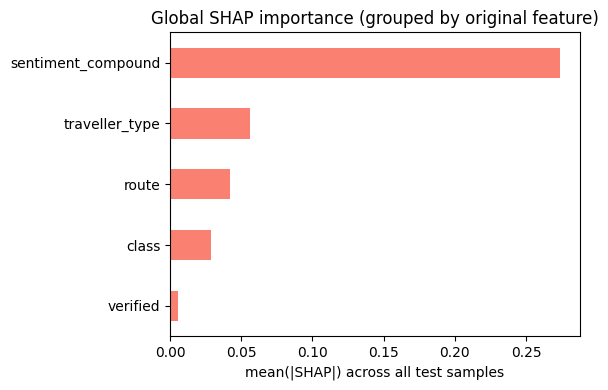

In [37]:
# SHAP explainability 
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

num_features = ["sentiment_compound"]
cat_features = [c for c in ["traveller_type", "class", "verified", "route"] if c in X.columns]

ohe = preprocessor.named_transformers_["cat"]
ohe_names = ohe.get_feature_names_out(cat_features)
feature_names = list(num_features) + list(ohe_names)

X_test_df = pd.DataFrame(X_test_prep, columns=feature_names)

def predict_fn(X): 
    return ffnn.predict(X, verbose=0)

background = shap.sample(X_test_df, 100, random_state=42)
explainer = shap.Explainer(predict_fn, background)
shap_values = explainer(X_test_df)

shap_abs = np.abs(shap_values.values)
shap_mean = pd.DataFrame(shap_abs, columns=feature_names).mean()

group_map = {f: next((c for c in cat_features if f.startswith(c + "_")), f) for f in feature_names}

grouped_importance = shap_mean.groupby(group_map).sum().sort_values(ascending=False)

plt.figure(figsize=(6,4))
grouped_importance.plot(kind="barh", color="salmon")
plt.gca().invert_yaxis()
plt.title("Global SHAP importance (grouped by original feature)")
plt.xlabel("mean(|SHAP|) across all test samples")
plt.tight_layout()
plt.show()


Step 9 — Global SHAP Explainability (Grouped by Feature)

In this step, we use SHAP (SHapley Additive exPlanations) to understand how each input feature influences the neural network’s predictions — on average, across all test samples.

What SHAP Does

SHAP assigns each feature a value that shows how much it increases or decreases the predicted satisfaction.
Positive SHAP values → higher chance of satisfaction
Negative SHAP values → lower chance of satisfaction

Process

We rebuild the feature names after one-hot encoding to match the model input.

We create a SHAP explainer using the trained FFNN model and a random background sample from the test data.

SHAP values are calculated for all test samples.

We take the absolute mean of SHAP values and group them back to their original features (so all traveller_type_* values are merged into one group).

Visualization

A bar chart shows the average influence (mean |SHAP|) of each main feature:

The longer the bar, the more impact that feature has on satisfaction predictions.

Example: If “sentiment_compound” has the longest bar, it’s the most important feature overall.

This gives a clear view of which factors drive the model’s predictions globally.

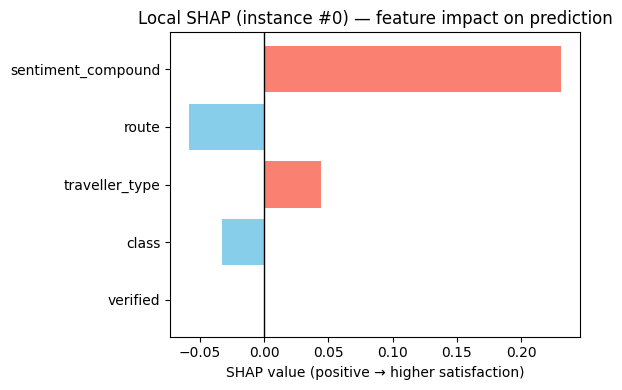

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Prediction for instance 0: 0.668

Top contributing features:


shap_value  abs_value
group                                    
sentiment_compound    0.231310   0.231310
route                -0.058783   0.076180
traveller_type        0.044245   0.060255
class                -0.032658   0.033934
verified              0.000188   0.000589

In [38]:
# --- Local SHAP
i = 0  # you can change this index


local_vals = shap_values.values[i]
local_df = pd.DataFrame({
    "feature": feature_names,
    "shap_value": local_vals,
    "abs_value": np.abs(local_vals)
})

local_df["group"] = local_df["feature"].apply(
    lambda f: next((c for c in cat_features if f.startswith(c + "_")), f)
)

local_grouped = local_df.groupby("group")[["shap_value", "abs_value"]].sum()

local_grouped = local_grouped.sort_values("abs_value", ascending=True)

plt.figure(figsize=(6,4))
colors = local_grouped["shap_value"].apply(lambda x: "salmon" if x > 0 else "skyblue")
plt.barh(local_grouped.index, local_grouped["shap_value"], color=colors)
plt.axvline(0, color="black", lw=1)
plt.title(f"Local SHAP (instance #{i}) — feature impact on prediction")
plt.xlabel("SHAP value (positive → higher satisfaction)")
plt.tight_layout()
plt.show()

print(f"\nPrediction for instance {i}: {ffnn.predict(X_test_prep[i:i+1])[0][0]:.3f}")
print("\nTop contributing features:")
display(local_grouped.sort_values('abs_value', ascending=False).head())


Step 10 — Local SHAP Explanation (Single Instance)

Now, we zoom in to understand how the model made one specific prediction (for a single passenger).

Process

We pick one test example (index i).

SHAP values for that specific instance are extracted.

One-hot features are grouped back to their original categories (traveller_type, class, etc.).

The grouped SHAP values show how much each feature pushed the prediction up or down.

Visualization

A horizontal bar chart displays feature contributions:

Red bars (salmon): push the prediction higher (more likely satisfied)

Blue bars (skyblue): push it lower (less likely satisfied)

The model’s actual prediction probability is also printed.

This helps interpret why the model predicted that a particular passenger would be satisfied or not — for example, because of a positive sentiment score or a specific travel class.

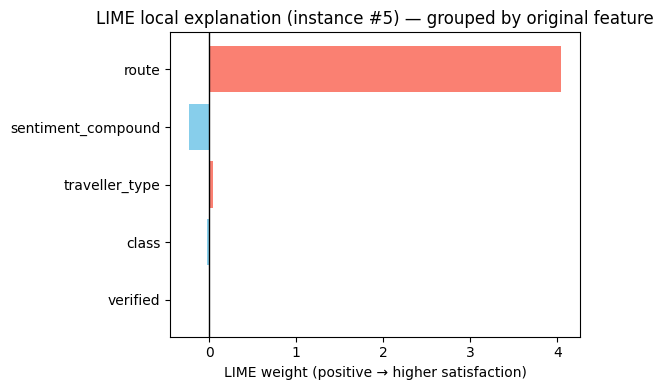

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Predicted satisfaction for instance 5: 0.255

Grouped LIME contributions:


group    weight       abs
3               route  4.046864  4.046864
4  sentiment_compound -0.233666  0.233666
5      traveller_type  0.046071  0.046071
2               class -0.019257  0.019257
6            verified  0.004087  0.004087

In [39]:
# --- 10) LIME 
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ohe = preprocessor.named_transformers_["cat"]
ohe_names = ohe.get_feature_names_out(cat_features)
feature_names = list(num_features) + list(ohe_names)

X_train_df = pd.DataFrame(X_train_prep, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_prep,  columns=feature_names)

predict_fn = lambda X: np.concatenate(
    [1 - ffnn.predict(X, verbose=0), ffnn.predict(X, verbose=0)], axis=1
)

explainer_lime = LimeTabularExplainer(
    X_train_df.values,
    feature_names=feature_names,
    class_names=["Not Satisfied", "Satisfied"],
    discretize_continuous=True
)

i = 5
exp = explainer_lime.explain_instance(
    X_test_df.values[i],
    predict_fn,
    num_features=len(feature_names)  
)


lime_df = pd.DataFrame(exp.as_list(), columns=["feature", "weight"])


def map_to_group(f):
    
    if any(num in f for num in num_features):
        return num_features[0]  
    for c in cat_features:
        if f.startswith(c + "_"):
            return c
    return f.split("=")[0].strip()

lime_df["group"] = lime_df["feature"].apply(map_to_group)

grouped_lime = lime_df.groupby("group")["weight"].sum().reset_index()

grouped_lime = grouped_lime[grouped_lime["group"].isin(base_features)]

grouped_lime["abs"] = grouped_lime["weight"].abs()
grouped_lime = grouped_lime.sort_values("abs", ascending=True)

plt.figure(figsize=(6,4))
colors = grouped_lime["weight"].apply(lambda x: "salmon" if x > 0 else "skyblue")
plt.barh(grouped_lime["group"], grouped_lime["weight"], color=colors)
plt.axvline(0, color="black", lw=1)
plt.title(f"LIME local explanation (instance #{i}) — grouped by original feature")
plt.xlabel("LIME weight (positive → higher satisfaction)")
plt.tight_layout()
plt.show()

print(f"\nPredicted satisfaction for instance {i}: {ffnn.predict(X_test_prep[i:i+1])[0][0]:.3f}")
print("\nGrouped LIME contributions:")
display(grouped_lime.sort_values("abs", ascending=False))


Step 11 — LIME Explainability (Grouped by Original Features)

After interpreting the model with SHAP, we now use LIME (Local Interpretable Model-agnostic Explanations) to understand how individual features influenced a single model prediction.

What LIME Does

LIME builds a simple, interpretable local model around one chosen data point (a single passenger).
It tests how small changes in input features affect the model’s output — showing which factors contributed most to that specific prediction.

1. Data Preparation

We reuse the same transformed inputs used by the neural network (X_train_prep and X_test_prep), including all encoded categorical features.

Feature names are reconstructed after one-hot encoding.

2. Model Wrapper for LIME

A prediction function (predict_fn) is defined so that LIME can query the neural network.

The function returns two probabilities:

Column 0 → Not Satisfied

Column 1 → Satisfied

3. LIME Explanation

We pick one instance (here, index i = 5) from the test set.

LIME perturbs this instance (slightly changes feature values) and observes how the prediction changes.

The resulting feature impacts are stored as weights — positive weights push the prediction toward “Satisfied”, and negative weights lower it.

4. Grouping and Simplification

One-hot encoded features (e.g., class_business, class_economy) are grouped back under their main feature name (class).

Only the main five input groups are kept:

traveller_type

class

verified

route

sentiment_compound

This simplifies interpretation to the same level as the original dataset.

5. Visualization

A horizontal bar chart shows how each main feature affected the satisfaction prediction for this specific passenger:

Red bars (salmon) → push the prediction higher (more likely satisfied).

Blue bars (skyblue) → push it lower (less likely satisfied).

6. Summary

The code also prints:

The model’s predicted satisfaction probability for this instance.

A ranked table of features showing which ones had the strongest local effect.

In [40]:

def infer_passenger(traveller_type, flight_class, verified, route, sentiment_compound):
    """
    Takes raw feature inputs, preprocesses them, and returns the model prediction.
    """

    data = pd.DataFrame([{
        "traveller_type": traveller_type.lower().strip(),
        "class": flight_class.lower().strip(),
        "verified": str(verified).lower().strip(),
        "route": route.lower().strip(),
        "sentiment_compound": float(sentiment_compound)
    }])

    data_prep = preprocessor.transform(data)
    if not isinstance(data_prep, np.ndarray):
        data_prep = data_prep.toarray()

    prob = ffnn.predict(data_prep, verbose=0)[0][0]
    label = "Satisfied" if prob >= 0.5 else "Not Satisfied"

    return {"Prediction": label, "Probability": float(prob)}

infer_passenger(
    traveller_type="Business",
    flight_class="Economy",
    verified=True,
    route="cairo to london",
    sentiment_compound=0.72
)



{'Prediction': 'Satisfied', 'Probability': 0.5300499796867371}

Step 12 — Inference Function (Model Deployment Simulation)

This final step creates a simple inference function that allows the trained model to make predictions on new passenger inputs, just like it would in a real-world application.

Goal

The function infer_passenger() takes raw input features from a user or system (e.g., traveler type, flight class, route, sentiment score) and returns whether the passenger is likely to be satisfied or not satisfied.

Step-by-Step Process

Input Collection

The function accepts five inputs:

traveller_type (e.g., “Business”, “Couple Leisure”)

flight_class (e.g., “Economy”, “Business”)

verified (True/False)

route (e.g., “cairo to london”)

sentiment_compound (numeric score from sentiment analysis)

These are the same features used during training.

Data Formatting & Cleaning

A one-row DataFrame is created to simulate a new record.

All text inputs are lowercased and stripped of spaces to match the model’s training format.

The numeric sentiment score is safely converted to a float.

Preprocessing

The input row is passed through the same preprocessor (StandardScaler + OneHotEncoder) used during model training.

This ensures the model sees data in the exact same format as it did before.

Prediction

The preprocessed row is fed into the trained Feed-Forward Neural Network (FFNN).

The model outputs a probability between 0 and 1:

Values ≥ 0.5 → “Satisfied”

Values < 0.5 → “Not Satisfied”

Output

The function returns a dictionary containing:

Prediction: The predicted label (“Satisfied” / “Not Satisfied”)

Probability: The model’s confidence score